# 🎯 目標三：數位資源差異與學習投入關聯分析（含時間轉換）

本 Notebook 探討家庭 SES、數位資源近用品質、使用模式與學習表現間的關聯，並處理原始時間型文字為數值，適用於 as35 系列變項。

## 📥 載入學生、家長、學校資料

In [22]:
import pandas as pd
from pandas.api.types import CategoricalDtype

# 載入資料（請確認檔案與 Notebook 同一資料夾）
df_s = pd.read_csv("../data/TIGPSw1_s_descriptive_labeled.csv")
df_p = pd.read_csv("../data/TIGPSw1_p_descriptive_labeled.csv")
df_sc = pd.read_csv("../data/TIGPSw1_sc_descriptive_labeled.csv")

print(df_s.shape, df_p.shape, df_sc.shape)


C:\Users\user\AppData\Local\Temp\ipykernel_22952\2667815177.py:5: DtypeWarning: Columns (7,19,29,152,368,383,483,507,529,577,579,603,627) have mixed types. Specify dtype option on import or set low_memory=False.
  df_s = pd.read_csv("../data/TIGPSw1_s_descriptive_labeled.csv")


(8958, 688) (4495, 563) (175, 138)


C:\Users\user\AppData\Local\Temp\ipykernel_22952\2667815177.py:6: DtypeWarning: Columns (16,18,34,262,281,291,451,473,482,484,499,561) have mixed types. Specify dtype option on import or set low_memory=False.
  df_p = pd.read_csv("../data/TIGPSw1_p_descriptive_labeled.csv")


## 🔗 合併資料（依學生 ID 與學校 ID）

In [23]:
# 確保不重複合併 '學校 ID' 欄位
df_p_filtered = df_p.drop(columns=['學校 ID'], errors='ignore')
df = df_s.merge(df_p_filtered, on='學生 ID', how='left')
df = df.merge(df_sc, on='學校 ID', how='left')
import pandas as pd

# 指定家境順序（從很不富裕到很富裕）
family_order = ['很不富裕', '不富裕', '經濟普通', '富裕', '很富裕']

# 建立有順序的類別型別
family_dtype = CategoricalDtype(categories=family_order, ordered=True)

# 指定順序（不移除任何值）
df['請問您認為家裡的經濟狀況為何？'] = df['請問您認為家裡的經濟狀況為何？'].astype(family_dtype)

grade_order = [
    '全班五名以內',
    '全班六至十名',
    '全班十一至二十名',
    '全班二十一至三十名',
    '全班三十名以後'
]

grade_dtype = pd.CategoricalDtype(categories=grade_order, ordered=True)

# 假設欄位名稱是「你上學期的平均成績大約如何？」
df['你上學期的平均成績大約如何?'] = df['你上學期的平均成績大約如何?'].replace(
    ['我不知道', '系統遺漏值', '此卷未答'], pd.NA
)
df['你上學期的平均成績大約如何?'] = df['你上學期的平均成績大約如何?'].astype(grade_dtype)
print(df.shape)


(10008, 1386)


## ⏱️ 文字時間轉換為數值：as35 系列

In [24]:
time_mapping = {
    "沒有": 0.0, "0.5小時以內": 0.25, "0.5-1小時": 0.75, "1-1.5小時": 1.25,
    "1.5-2小時": 1.75, "2-2.5小時": 2.25, "2.5-3小時": 2.75, "3-3.5小時": 3.25,
    "3.5-4小時": 3.75, "4-4.5小時": 4.25, "4.5-5小時": 4.75, "5小時以上": 5.5
}

time_cols = [
    "完成學校功課(查找完成作業需要的資料)",
    "課外的學習(各種線上付費或免費的課程)",
    "玩線上遊戲",
    "看影片、聽音樂、迷因梗圖、卡通、漫畫",
    "和他人聊天(傳訊息)"
]

for col in time_cols:
    df[col + "_num"] = df[col].map(time_mapping)

df['total_time'] = df[[c + "_num" for c in time_cols]].sum(axis=1)

df['study_ratio'] = (
    df["完成學校功課(查找完成作業需要的資料)_num"] +
    df["課外的學習(各種線上付費或免費的課程)_num"]
) / df['total_time']

df['entertainment_ratio'] = (
    df["玩線上遊戲_num"] +
    df["看影片、聽音樂、迷因梗圖、卡通、漫畫_num"] +
    df["和他人聊天(傳訊息)_num"]
) / df['total_time']


## 📊 敘述統計：數位資源、SES、自評家境與使用時間

In [25]:
print("數位資源品質：")
print(df[['對我來說,要購買3C產品(手機、電腦、平板)的費用太高。', '我住的地方沒有網路訊號或是訊號太弱。', '對我來說,使用網路要付的費用太貴。', '對我來說,很難找到一個不受干擾的空間來上網。']].describe(include='all'))

print("\nSES：")
print(df[['請問您的學歷', '請問您認為家裡的經濟狀況為何？']].value_counts())

print("\n學習時間比例")
print(df[['study_ratio', 'entertainment_ratio']].describe())

from scipy.stats import spearmanr, kendalltau
# 1. 定義欄位
digital_quality_cols = [
    '對我來說,要購買3C產品(手機、電腦、平板)的費用太高。',
    '我住的地方沒有網路訊號或是訊號太弱。',
    '對我來說,使用網路要付的費用太貴。',
    '對我來說,很難找到一個不受干擾的空間來上網。'
]
study_cols = ['study_ratio', 'entertainment_ratio']

# 2. 擷取分析用的資料
df_corr = df[digital_quality_cols + study_cols].copy()

# 3. Spearman 與 Kendall 分析
for dq_col in digital_quality_cols:
    for study_col in study_cols:
        # 先移除缺漏值
        temp_df = df_corr[[dq_col, study_col]].dropna()
        
        # 計算 Spearman
        rho, p_spearman = spearmanr(temp_df[dq_col], temp_df[study_col])
        
        # 計算 Kendall
        tau, p_kendall = kendalltau(temp_df[dq_col], temp_df[study_col])

        # 輸出結果
        print(f"\n=== 數位資源品質：{dq_col} × {study_col} ===")
        print(f"Spearman ρ = {rho:.5f}, p-value = {p_spearman:.5e}")
        print(f"Kendall τ = {tau:.5f}, p-value = {p_kendall:.5e}")


數位資源品質：
       對我來說,要購買3C產品(手機、電腦、平板)的費用太高。 我住的地方沒有網路訊號或是訊號太弱。 對我來說,使用網路要付的費用太貴。  \
count                         10008              10008             10008   
unique                            6                  6                 6   
top                            此卷未答               此卷未答              此卷未答   
freq                           4674               4674              4674   

       對我來說,很難找到一個不受干擾的空間來上網。  
count                   10008  
unique                      6  
top                      此卷未答  
freq                     4674  

SES：
請問您的學歷    請問您認為家裡的經濟狀況為何？
大學、二技、四技  富裕                 960
五專、二專     富裕                 467
碩士        富裕                 462
高中職       富裕                 451
國（初）中     富裕                  44
博士        富裕                  43
大學、二技、四技  很富裕                 18
小學        富裕                  14
高中職       很富裕                 14
碩士        很富裕                  5
五專、二專     很富裕                  5
無／不識字     富裕                   4
博士        很富裕          

## 🧮 SES 與網路品質 (as57b) 關聯

=== Spearman 等級相關係數 ===
Spearman ρ = 0.02192, p-value = 4.16804e-01

=== Kendall 等級相關係數 ===
Kendall τ = 0.02105, p-value = 4.16605e-01


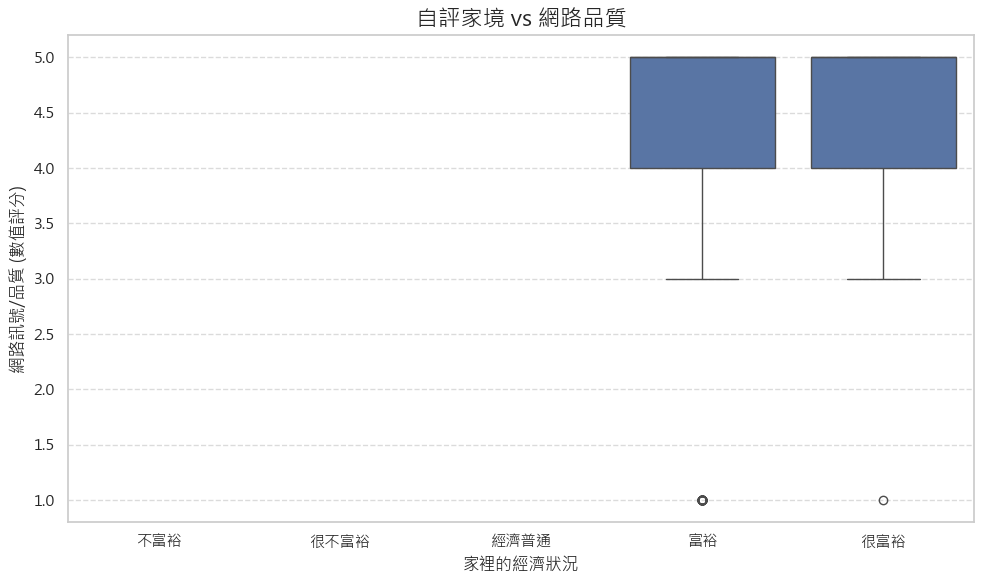

In [26]:
from scipy.stats import spearmanr, kendalltau
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # 確保有導入 pandas 函式庫


# 設定中文字體與樣式，讓圖表能正確顯示中文
sns.set(font="Microsoft JhengHei", style="whitegrid")

# --- 定義經濟狀況的映射規則 ---
# 數值越高代表經濟狀況越好。
# **非常重要：請務必根據您資料中『請問您認為家裡的經濟狀況為何？』欄位的實際文字內容來調整這些鍵 (key)。**
# 根據您之前的輸出，您的實際資料可能包含「富裕」、「很富裕」等，而不是「非常不好」、「不好」。
# 以下是我根據您提供的資料內容來修正的映射範例：
economic_map = {
    "不富裕": 1,         # 範例：最低的經濟狀況
    "很不富裕": 1,       # 如果這兩者意義相近，可以給予相同較低的數值
    "經濟普通": 2,       # 範例：一般
    "富裕": 4,           # 範例：較好的經濟狀況
    "很富裕": 5,         # 範例：最好的經濟狀況
    # 如果您的資料中還有其他經濟狀況的描述，請務必在這裡補齊並給予對應的數值
}

# --- 定義網路品質（李克特量表）的映射規則 ---
# 這裡假設「從未」出現網路訊號問題代表網路最好（給予較高分數），
# 而「經常」出現問題則代表網路最差（給予較低分數）。
# **非常重要：請務必根據您資料中『我住的地方沒有網路訊號或是訊號太弱。』欄位的實際文字內容來調整這些鍵 (key)。**
# 根據您之前的輸出，您的實際資料包含「從未」、「偶爾」、「有時」、「經常」、「此卷未答」、「系統遺漏值」。
internet_quality_map = {
    "從未": 5,           # 從未有訊號問題 = 網路品質最好
    "偶爾": 4,           # 偶爾有問題
    "有時": 3,           # 有時有問題
    "經常": 1,           # 經常有問題 = 網路品質最差
    # 「此卷未答」和「系統遺漏值」這些通常應視為缺失值，並會在後續的 dropna() 步驟中被移除。
    # 因此，通常不需要將它們包含在映射中，除非您希望它們映射到特定數值。
}

# --- 準備用於相關分析的 DataFrame ---
# 1. 選取所需的欄位，並使用 .copy() 避免 SettingWithCopyWarning 警告。
# 2. 先移除原始資料中任一欄位有 NaN 的列。
df_corr = df[['請問您認為家裡的經濟狀況為何？', '我住的地方沒有網路訊號或是訊號太弱。']].dropna().copy()

# 3. 應用映射規則，將文字轉換為數值。
#    如果原始文字在映射字典中找不到對應，結果會變成 NaN。
df_corr['經濟狀況_數值'] = df_corr['請問您認為家裡的經濟狀況為何？'].map(economic_map)
df_corr['網路品質_數值'] = df_corr['我住的地方沒有網路訊號或是訊號太弱。'].map(internet_quality_map)

# 4. 在映射完成後，再次移除因為轉換失敗（例如，原始資料有 map 中沒有的文字）而產生的 NaN 列。
#    這一步是為了確保用於相關分析的資料都是純數值。
df_corr.dropna(subset=['經濟狀況_數值', '網路品質_數值'], inplace=True)

# 5. 確保最終用於計算的欄位都是數值型別，增加程式的穩健性。
df_corr['經濟狀況_數值'] = pd.to_numeric(df_corr['經濟狀況_數值'])
df_corr['網路品質_數值'] = pd.to_numeric(df_corr['網路品質_數值'])

# --- 執行等級相關分析 ---
# 現在兩個欄位都已是經過處理且乾淨的數值，可以正確計算相關係數了。
rho, p_spearman = spearmanr(df_corr['經濟狀況_數值'], df_corr['網路品質_數值'])
tau, p_kendall = kendalltau(df_corr['經濟狀況_數值'], df_corr['網路品質_數值'])

# --- 顯示結果 ---
print("=== Spearman 等級相關係數 ===")
print(f"Spearman ρ = {rho:.5f}, p-value = {p_spearman:.5e}")
print("\n=== Kendall 等級相關係數 ===")
print(f"Kendall τ = {tau:.5f}, p-value = {p_kendall:.5e}")


# --- 繪圖 ---
plt.figure(figsize=(10, 6)) # 將圖表尺寸稍微放大，以便閱讀
# X 軸使用原始的類別型經濟狀況，Y 軸則使用數值化的網路品質。
# 使用 'order' 參數來確保 X 軸的類別能按照您定義的映射順序來顯示。
sns.boxplot(data=df_corr,
            x='請問您認為家裡的經濟狀況為何？',
            y='網路品質_數值',
            order=list(economic_map.keys())) # 確保 X 軸的顯示順序與您的映射一致

plt.title('自評家境 vs 網路品質', fontsize=16) # 設定圖表標題及字體大小
plt.xlabel('家裡的經濟狀況', fontsize=12) # 設定 X 軸標籤及字體大小
plt.ylabel('網路訊號/品質 (數值評分)', fontsize=12) # 更清楚的 Y 軸標籤
plt.grid(axis='y', linestyle='--', alpha=0.7) # 添加 Y 軸格線，增加可讀性
plt.tight_layout() # 自動調整佈局，避免標籤重疊
plt.show()

## 🔁 SES vs 使用模式比例相關性

In [27]:
print(df[['請問您認為家裡的經濟狀況為何？', 'study_ratio']].corr(numeric_only=True))


             study_ratio
study_ratio          1.0


## 📈 使用比例或網路品質 vs 成績 (as20)


--- 學習時間比例 vs 學業表現 分析後的行數：4175 ---
=== 學習時間比例 vs 學業表現 ===
Spearman ρ = 0.03780, p-value = 1.45856e-02
Kendall τ = 0.02860, p-value = 1.36034e-02


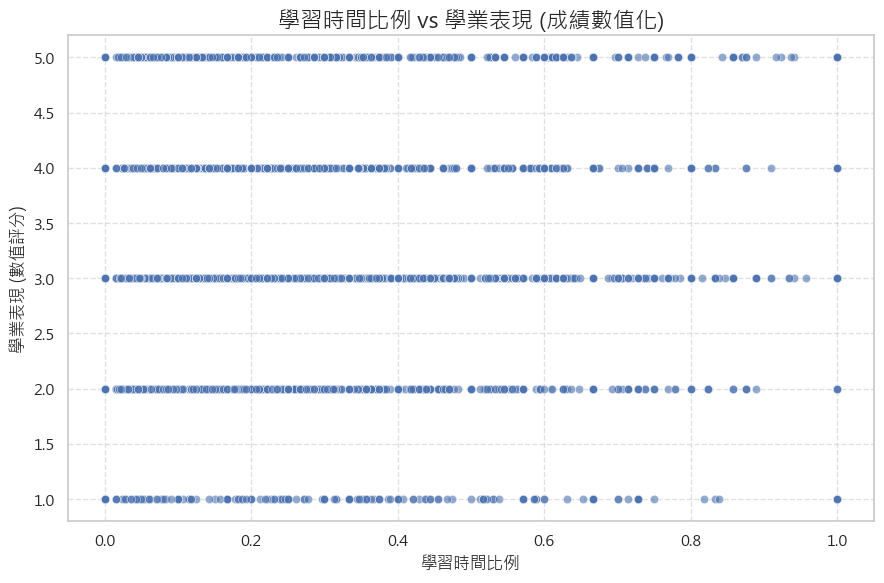


--- 網路品質 vs 學業表現 分析後的行數：4753 ---

=== 網路品質 vs 學業表現 ===
Spearman ρ = 0.04460, p-value = 2.09921e-03
Kendall τ = 0.03868, p-value = 2.05925e-03


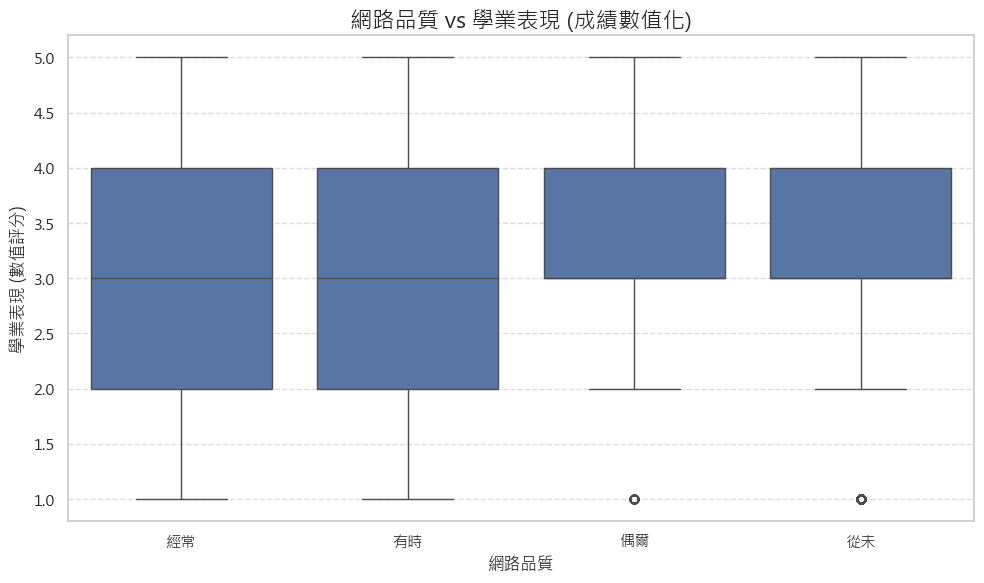

In [28]:
import pandas as pd
from scipy.stats import spearmanr, kendalltau
import seaborn as sns
import matplotlib.pyplot as plt

# 設定中文字體與樣式
sns.set(font="Microsoft JhengHei", style="whitegrid")

# --- 定義學業成績的映射規則 ---
# 根據您 '你上學期的平均成績大約如何?' 的實際唯一值來建立映射
# 數值越高代表成績越好
grade_map = {
    "全班三十名以後": 1,
    "全班二十一至三十名": 2,
    "全班十一至二十名": 3,
    "全班六至十名": 4,
    "全班五名以內": 5,
    # 如果有其他未列出的值，會被 map 成 NaN
}

# --- 定義網路品質的映射規則 ---
# 數值越高代表網路品質越好
# 根據您 '我住的地方沒有網路訊號或是訊號太弱。' 的實際唯一值來建立映射
internet_quality_map = {
    "經常": 1,           # 經常有問題 = 網路品質最差
    "有時": 2,
    "偶爾": 3,
    "從未": 5,           # 從未有訊號問題 = 網路品質最好
    "此卷未答": None,    # 這些值通常應被視為缺失，在 dropna() 中會被處理
    "系統遺漏值": None   # 這些值通常應被視為缺失，在 dropna() 中會被處理
}

# --- 1️⃣ 散點圖與相關分析：學習時間比例 vs 學業表現 ---

# 準備數據：選取相關欄位並複製，避免 SettingWithCopyWarning
df_corr1 = df[['study_ratio', '你上學期的平均成績大約如何?']].copy()

# 將成績轉換為數值型（使用我們定義的 grade_map）
df_corr1['成績數值'] = df_corr1['你上學期的平均成績大約如何?'].map(grade_map)

# 移除任何包含 NaN 的行（包括 study_ratio 原始的 NaN，和轉換後成績產生的 NaN）
df_corr1.dropna(subset=['study_ratio', '成績數值'], inplace=True)

# 確保 study_ratio 是數值型（雖然 info 顯示是 float64，但穩健性考慮加上）
df_corr1['study_ratio'] = pd.to_numeric(df_corr1['study_ratio'], errors='coerce')
df_corr1['成績數值'] = pd.to_numeric(df_corr1['成績數值'], errors='coerce')
df_corr1.dropna(subset=['study_ratio', '成績數值'], inplace=True) # 再次清理

print(f"\n--- 學習時間比例 vs 學業表現 分析後的行數：{len(df_corr1)} ---")
if len(df_corr1) > 0: # 確保有資料才進行計算
    # Spearman 等級相關
    rho1, p_spearman1 = spearmanr(df_corr1['study_ratio'], df_corr1['成績數值'])
    # Kendall 等級相關
    tau1, p_kendall1 = kendalltau(df_corr1['study_ratio'], df_corr1['成績數值'])

    # 顯示結果
    print("=== 學習時間比例 vs 學業表現 ===")
    print(f"Spearman ρ = {rho1:.5f}, p-value = {p_spearman1:.5e}")
    print(f"Kendall τ = {tau1:.5f}, p-value = {p_kendall1:.5e}")

    # 繪製散點圖
    plt.figure(figsize=(9, 6))
    sns.scatterplot(data=df_corr1, x='study_ratio', y='成績數值', alpha=0.6) # 使用數值成績
    plt.title("學習時間比例 vs 學業表現 (成績數值化)", fontsize=16)
    plt.xlabel('學習時間比例', fontsize=12)
    plt.ylabel('學業表現 (數值評分)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("學習時間比例 vs 學業表現：無足夠資料進行分析。")


# --- 2️⃣ 箱型圖與相關分析：網路品質 vs 學業表現 ---

# 準備數據：選取相關欄位並複製
df_corr2 = df[['我住的地方沒有網路訊號或是訊號太弱。', '你上學期的平均成績大約如何?']].copy()

# 將網路品質轉換為數值型（使用 internet_quality_map）
df_corr2['網路品質_數值'] = df_corr2['我住的地方沒有網路訊號或是訊號太弱。'].map(internet_quality_map)
# 將成績轉換為數值型（使用 grade_map）
df_corr2['成績數值'] = df_corr2['你上學期的平均成績大約如何?'].map(grade_map)


# 移除任何包含 NaN 的行（包括原始的 NaN，和轉換後產生的 NaN）
df_corr2.dropna(subset=['網路品質_數值', '成績數值'], inplace=True)

# 確保最終型別為數值
df_corr2['網路品質_數值'] = pd.to_numeric(df_corr2['網路品質_數值'], errors='coerce')
df_corr2['成績數值'] = pd.to_numeric(df_corr2['成績數值'], errors='coerce')
df_corr2.dropna(subset=['網路品質_數值', '成績數值'], inplace=True) # 再次清理

print(f"\n--- 網路品質 vs 學業表現 分析後的行數：{len(df_corr2)} ---")
if len(df_corr2) > 0: # 確保有資料才進行計算
    # Spearman 等級相關
    rho2, p_spearman2 = spearmanr(df_corr2['網路品質_數值'], df_corr2['成績數值'])
    # Kendall 等級相關
    tau2, p_kendall2 = kendalltau(df_corr2['網路品質_數值'], df_corr2['成績數值'])

    # 顯示結果
    print("\n=== 網路品質 vs 學業表現 ===")
    print(f"Spearman ρ = {rho2:.5f}, p-value = {p_spearman2:.5e}")
    print(f"Kendall τ = {tau2:.5f}, p-value = {p_kendall2:.5e}")

    # 繪製箱型圖
    plt.figure(figsize=(10, 6))
    # 這裡 X 軸使用原始的網路品質文字，Y 軸使用數值成績。
    # 確保 X 軸的順序是依據 internet_quality_map 的數值順序來排列，更具可讀性。
    sns.boxplot(data=df_corr2,
                x='我住的地方沒有網路訊號或是訊號太弱。',
                y='成績數值',
                order=[k for k in internet_quality_map if internet_quality_map[k] is not None]) # 排除 None 的鍵
    plt.title("網路品質 vs 學業表現 (成績數值化)", fontsize=16)
    plt.xlabel('網路品質', fontsize=12)
    plt.ylabel('學業表現 (數值評分)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("網路品質 vs 學業表現：無足夠資料進行分析。")

## 🏫 學校層級支援變項分佈

In [29]:
import pandas as pd
from scipy.stats import spearmanr, kendalltau
import seaborn as sns
import matplotlib.pyplot as plt

# 設定中文字體與樣式
sns.set(font="Microsoft JhengHei", style="whitegrid")

# --- 定義學業成績的映射規則 (與您檢查時使用的相同，已確認有效) ---
grade_map = {
    "全班三十名以後": 1,
    "全班二十一至三十名": 2,
    "全班十一至二十名": 3,
    "全班六至十名": 4,
    "全班五名以內": 5,
}

# --- 定義各個學校支援欄位的映射規則 ---
# 這些是新的且重要的部分！
# 請仔細檢查並根據您的問卷實際意義調整數值。
# 通常，分數越高代表越「好」或越「多」的支援。

# 1. 課程節數：'貴校目前開設的選修類型的資訊課程... 每週共 節'
# 原始唯一值: ['0', '4', '10', '2', '3', '1', '5', '6', '系統遺漏值', '16', '8', '14']
# 這裡將字串數字轉換為實際數字。 '系統遺漏值' 應該在 dropna 中處理。
course_hours_map = {str(i): i for i in range(20)} # 假設課程節數從 0 到 19
course_hours_map['系統遺漏值'] = None # 將此視為缺失值

# 2. 社團數量：'貴校有幾個與資訊相關的...社團或代表隊有 個'
# 原始唯一值: ['2', '5', '3', '0', '1', '6', '4', '系統遺漏值', '46']
# 46 可能是極端值或錯誤輸入，如果確定是錯誤，可以考慮設定為 None 或平均值
club_count_map = {str(i): i for i in range(10)} # 假設社團數量從 0 到 9
club_count_map['系統遺漏值'] = None
club_count_map['46'] = 46 # 如果 46 是有效值，則保留

# 3. 提升頻寬：'除臺灣學術網路外,本校另行付費提升頻寬'
# 原始唯一值: ['很符合', '符合', '系統遺漏值', '不符合', '很不符合']
bandwidth_map = {
    "很不符合": 1,
    "不符合": 2,
    "符合": 3,
    "很符合": 4,
    "系統遺漏值": None
}

# 4. 硬體設備：'本校固定購置/導入支持課室數位互動的硬體設備...'
# 原始唯一值: ['符合', '很符合', '不符合', '很不符合', '系統遺漏值']
hardware_map = {
    "很不符合": 1,
    "不符合": 2,
    "符合": 3,
    "很符合": 4,
    "系統遺漏值": None
}

# 5. 借用與管理機制：'本校的資訊設備借用與管理機制運作完善'
# 原始唯一值: ['符合', '很符合', '很不符合', '不符合', '系統遺漏值']
management_map = {
    "很不符合": 1,
    "不符合": 2,
    "符合": 3,
    "很符合": 4,
    "系統遺漏值": None
}

# 6. 人事或業務費支持：'本校能獲得推動數位學習充分的人事或業務費支持'
# 原始唯一值: ['符合', '很不符合', '很符合', '不符合', '系統遺漏值']
personnel_support_map = {
    "很不符合": 1,
    "不符合": 2,
    "符合": 3,
    "很符合": 4,
    "系統遺漏值": None
}

# 7. 設備費支持：'本校能獲得推動數位學習充分的設備費支持'
# 原始唯一值: ['符合', '不符合', '很符合', '系統遺漏值', '很不符合']
equipment_support_map = {
    "很不符合": 1,
    "不符合": 2,
    "符合": 3,
    "很符合": 4,
    "系統遺漏值": None
}


# 將所有映射字典放入一個大字典，方便迴圈處理
# 鍵是欄位名稱，值是該欄位的映射字典
all_school_support_maps = {
    '貴校目前開設的選修類型的資訊課程(彈性學習時數或加深加廣) 每週共 節': course_hours_map,
    '貴校有幾個與資訊相關的,常設的社團或代表隊有 個 (資訊相關社團如:資訊社、機器人社、遊戲開發社、數位音樂社、電子競技社、多媒體數位傳播社、手機攝影社、大眾傳播社等)': club_count_map,
    '除臺灣學術網路外,本校另行付費提升頻寬': bandwidth_map,
    '本校固定購置/導入支持課室數位互動的硬體設備(如大螢幕、短焦投影、Smartboard等)': hardware_map,
    '本校的資訊設備借用與管理機制運作完善': management_map,
    '本校能獲得推動數位學習充分的人事或業務費支持': personnel_support_map,
    '本校能獲得推動數位學習充分的設備費支持': equipment_support_map
}


# --- 相關分析主程式 ---
school_support_cols = [
    '貴校目前開設的選修類型的資訊課程(彈性學習時數或加深加廣) 每週共 節',
    '貴校有幾個與資訊相關的,常設的社團或代表隊有 個 (資訊相關社團如:資訊社、機器人社、遊戲開發社、數位音樂社、電子競技社、多媒體數位傳播社、手機攝影社、大眾傳播社等)',
    '除臺灣學術網路外,本校另行付費提升頻寬',
    '本校固定購置/導入支持課室數位互動的硬體設備(如大螢幕、短焦投影、Smartboard等)',
    '本校的資訊設備借用與管理機制運作完善',
    '本校能獲得推動數位學習充分的人事或業務費支持',
    '本校能獲得推動數位學習充分的設備費支持'
]
target_col = '你上學期的平均成績大約如何?'


# 複製一份 DataFrame，避免動到原始資料
df_corr = df[school_support_cols + [target_col]].copy()

# 1. 將成績轉換為數值
df_corr['成績數值'] = df_corr[target_col].map(grade_map)

# 2. 將所有學校支援欄位轉換為數值
for col, col_map in all_school_support_maps.items():
    df_corr[f'{col}_數值'] = df_corr[col].map(col_map)
    # 確保轉換後是數值型別 (雖然 map 應該會是，但多一層保護)
    df_corr[f'{col}_數值'] = pd.to_numeric(df_corr[f'{col}_數值'], errors='coerce')


# 迴圈計算每個學校支援欄位與學業表現的相關性
print("\n--- 各項學校支援與學業表現之相關性分析 ---")
for col in school_support_cols:
    numeric_col_name = f'{col}_數值' # 取得數值化後的欄位名稱

    # 處理缺失值：僅針對當前兩個要相關的欄位進行 dropna
    # 這確保了每個相關性計算都只使用有效的數據對
    temp_df = df_corr[[numeric_col_name, '成績數值']].dropna()

    # 檢查是否有足夠的資料進行計算
    if len(temp_df) < 2: # 至少需要2個數據點才能計算相關係數
        print(f"\n=== {col} × 學業表現 ===")
        print(f"**警告：'{col}' 與 '學業表現' 沒有足夠的有效數據進行相關性分析（僅有 {len(temp_df)} 行）。**")
        print("Spearman ρ = NaN, p-value = NaN")
        print("Kendall τ = NaN, p-value = NaN")
        continue # 跳過此次迴圈，繼續下一個欄位

    # Spearman
    rho, p_spearman = spearmanr(temp_df[numeric_col_name], temp_df['成績數值'])
    # Kendall
    tau, p_kendall = kendalltau(temp_df[numeric_col_name], temp_df['成績數值'])

    # 印出結果
    print(f"\n=== {col} × 學業表現 ===")
    print(f"Spearman ρ = {rho:.5f}, p-value = {p_spearman:.5e}")
    print(f"Kendall τ = {tau:.5f}, p-value = {p_kendall:.5e}")


--- 各項學校支援與學業表現之相關性分析 ---

=== 貴校目前開設的選修類型的資訊課程(彈性學習時數或加深加廣) 每週共 節 × 學業表現 ===
Spearman ρ = -0.08354, p-value = 7.25965e-15
Kendall τ = -0.07051, p-value = 7.63396e-15

=== 貴校有幾個與資訊相關的,常設的社團或代表隊有 個 (資訊相關社團如:資訊社、機器人社、遊戲開發社、數位音樂社、電子競技社、多媒體數位傳播社、手機攝影社、大眾傳播社等) × 學業表現 ===
Spearman ρ = -0.07804, p-value = 3.16054e-13
Kendall τ = -0.06391, p-value = 3.27631e-13

=== 除臺灣學術網路外,本校另行付費提升頻寬 × 學業表現 ===
Spearman ρ = -0.07585, p-value = 1.29726e-12
Kendall τ = -0.06310, p-value = 1.41381e-12

=== 本校固定購置/導入支持課室數位互動的硬體設備(如大螢幕、短焦投影、Smartboard等) × 學業表現 ===
Spearman ρ = -0.01701, p-value = 1.10084e-01
Kendall τ = -0.01475, p-value = 1.10690e-01

=== 本校的資訊設備借用與管理機制運作完善 × 學業表現 ===
Spearman ρ = -0.03200, p-value = 2.73670e-03
Kendall τ = -0.02859, p-value = 2.71996e-03

=== 本校能獲得推動數位學習充分的人事或業務費支持 × 學業表現 ===
Spearman ρ = -0.03030, p-value = 4.72477e-03
Kendall τ = -0.02587, p-value = 4.62216e-03

=== 本校能獲得推動數位學習充分的設備費支持 × 學業表現 ===
Spearman ρ = -0.05695, p-value = 9.54658e-08
Kendall τ = -0.04925, p-value = 8.

## 🧪 替代分析：不同學校支援程度下 SES 對成績影響

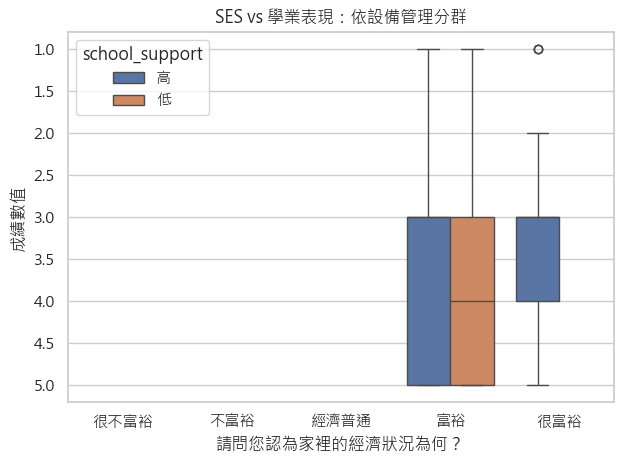


設備管理 高 組的 SES 與學業成績相關性：
Spearman ρ = -0.00714, p-value = 7.34418e-01
Kendall τ = -0.00649, p-value = 7.34336e-01

設備管理 低 組的 SES 與學業成績相關性：
Spearman ρ = nan, p-value = nan
Kendall τ = nan, p-value = nan


C:\Users\user\AppData\Local\Temp\ipykernel_22952\4029575517.py:52: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, p_spearman = spearmanr(subset['家境_數值'], subset['成績數值'])


In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau
from pandas.api.types import CategoricalDtype

# 1. 指定家境順序（從很不富裕到很富裕）
family_order = ['很不富裕', '不富裕', '經濟普通', '富裕', '很富裕']
family_dtype = CategoricalDtype(categories=family_order, ordered=True)

# 2. 將「家境」欄位轉成有序類別型別
df['請問您認為家裡的經濟狀況為何？'] = df['請問您認為家裡的經濟狀況為何？'].astype(family_dtype)

# 3. 建立設備管理分群欄位（根據文字內容）
df['school_support'] = df['本校的資訊設備借用與管理機制運作完善'].map(
    lambda x: '高' if x in ['很符合', '符合'] else ('低' if x in ['不符合', '很不符合'] else pd.NA)
)

# 4. 成績轉換為數值（將名次區間文字轉為數字分數）
grade_map = {
    "全班三十名以後": 1,
    "全班二十一至三十名": 2,
    "全班十一至二十名": 3,
    "全班六至十名": 4,
    "全班五名以內": 5
}
df['成績數值'] = df['你上學期的平均成績大約如何?'].map(grade_map)

# 5. 畫圖（只有轉換後的成績才能畫）
sns.boxplot(
    data=df,
    x='請問您認為家裡的經濟狀況為何？',
    y='成績數值',
    hue='school_support'
)
plt.title("SES vs 學業表現：依設備管理分群")
plt.tight_layout()
plt.show()

# 6. 等級相關分析：分「高」與「低」兩組
for group in ['高', '低']:
    subset = df[df['school_support'] == group][['請問您認為家裡的經濟狀況為何？', '成績數值']].dropna()

    if subset.empty:
        print(f"\n⚠️ 設備管理 {group} 組無資料可分析")
        continue

    # 轉換為數值方便相關分析
    subset['家境_數值'] = subset['請問您認為家裡的經濟狀況為何？'].cat.codes

    # Spearman 等級相關
    rho, p_spearman = spearmanr(subset['家境_數值'], subset['成績數值'])

    # Kendall 等級相關
    tau, p_kendall = kendalltau(subset['家境_數值'], subset['成績數值'])

    print(f"\n設備管理 {group} 組的 SES 與學業成績相關性：")
    print(f"Spearman ρ = {rho:.5f}, p-value = {p_spearman:.5e}")
    print(f"Kendall τ = {tau:.5f}, p-value = {p_kendall:.5e}")
